In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
data = pd.merge(transactions, customers, on='CustomerID', how='left')
data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11


In [4]:
customer_features = (
    data.groupby('CustomerID')
    .agg(
        avg_transaction_value=('TotalValue', 'mean'),
        total_purchases=('TransactionID', 'count'),
        total_quantity=('Quantity', 'sum')
    )
    .reset_index()
)

# Add the most frequent region separately
most_frequent_region = data.groupby('CustomerID')['Region'].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
customer_features = customer_features.merge(most_frequent_region.rename('region'), on='CustomerID')
customer_features

,CustomerID,avg_transaction_value,total_purchases,total_quantity,region
0,C0001,670.904000,5,12,South America
1,C0002,465.685000,4,10,Asia
2,C0003,681.345000,4,14,South America
3,C0004,669.360000,8,23,South America
4,C0005,678.080000,3,7,Asia
...,...,...,...,...,...
194,C0196,1245.720000,4,12,Europe
195,C0197,642.883333,3,9,Europe
196,C0198,465.915000,2,3,Europe
197,C0199,494.820000,4,9,Europe


In [5]:
#one-hot encoding region
customer_features = pd.get_dummies(customer_features, columns=['region'], drop_first=True)
customer_features

,CustomerID,avg_transaction_value,total_purchases,total_quantity,region_Europe,region_North America,region_South America
0,C0001,670.904000,5,12,False,False,True
1,C0002,465.685000,4,10,False,False,False
2,C0003,681.345000,4,14,False,False,True
3,C0004,669.360000,8,23,False,False,True
4,C0005,678.080000,3,7,False,False,False
...,...,...,...,...,...,...,...
194,C0196,1245.720000,4,12,True,False,False
195,C0197,642.883333,3,9,True,False,False
196,C0198,465.915000,2,3,True,False,False
197,C0199,494.820000,4,9,True,False,False


In [6]:
# Step 2: Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))
scaled_features

array([[-0.07026341, -0.01145819, -0.12203296, -0.57928445, -0.54831888,
         1.54041597],
       [-0.93493297, -0.46749414, -0.44800021, -0.57928445, -0.54831888,
        -0.6491753 ],
       [-0.02627131, -0.46749414,  0.20393428, -0.57928445, -0.54831888,
         1.54041597],
       ...,
       [-0.93396389, -1.37956603, -1.58888557,  1.72626765, -0.54831888,
        -0.6491753 ],
       [-0.81217559, -0.46749414, -0.61098383,  1.72626765, -0.54831888,
        -0.6491753 ],
       [ 1.11292648, -0.01145819,  0.52990153, -0.57928445, -0.54831888,
        -0.6491753 ]])

In [7]:
# Step 3: Clustering
# Determine the optimal number of clusters using DB Index
db_scores = []
silhouette_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, labels)
    silhouette_avg = silhouette_score(scaled_features, labels)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

In [8]:
# Select the number of clusters with the lowest DB Index
optimal_k = clusters_range[np.argmin(db_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Lowest DB Index: {min(db_scores)}")

# Train KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

Optimal Number of Clusters: 8
Lowest DB Index: 0.9820196353666438


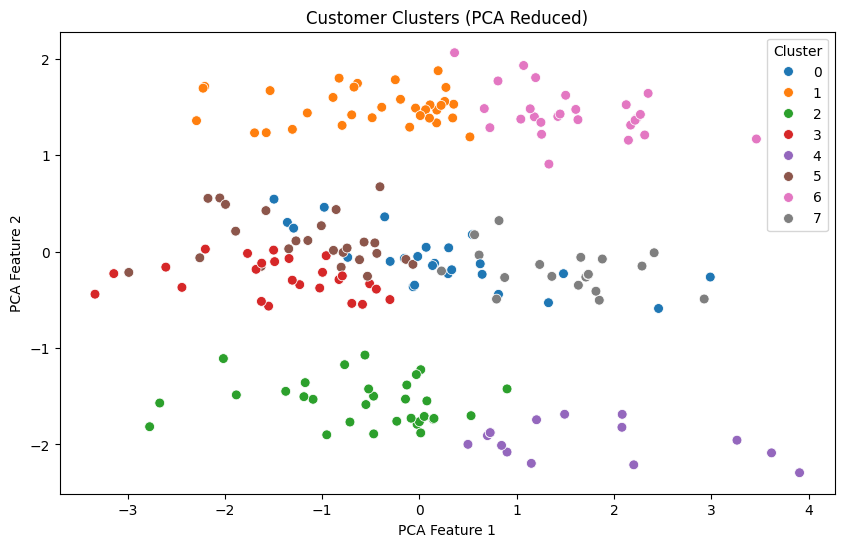

In [9]:
#visualization
# 2D Visualization using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=customer_features['Cluster'],
    palette='tab10',
    s=50
)
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.legend(title='Cluster')
plt.show()

In [10]:
# Step 5: Report Results
# DB Index and Silhouette Score
report = pd.DataFrame({'Clusters': clusters_range, 'DB Index': db_scores, 'Silhouette Score': silhouette_scores})
print(report)

# Save Clustering Results
customer_features.to_csv('Customer_Clusters.csv', index=False)

   Clusters  DB Index  Silhouette Score
0         2  1.831694          0.194528
1         3  1.428838          0.311165
2         4  1.195446          0.337076
3         5  1.105905          0.354516
4         6  1.091585          0.314243
5         7  1.029169          0.331628
6         8  0.982020          0.352756
7         9  1.042394          0.337134
8        10  1.008522          0.343505
